## Import packages and define the main training parameters

In [99]:
#Misc librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

#Pytorch main librairies
from PIL import Image
import torch


import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

#High-level ignite librairies for callbacks
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.metrics.regression import MedianAbsoluteError, MeanAbsoluteRelativeError, MeanError, R2Score


#Visualization
import logging
from ignite.contrib.handlers.tensorboard_logger import *
from ignite.contrib.handlers.param_scheduler import LRScheduler

#Seeding for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [100]:
class EsthDataset(torch.utils.data.Dataset):
  def __init__(self, path, transforms=None):
    # import and initialize dataset
    data = pd.read_csv(path, header=None, sep = ",")
    data.columns = ["names", "scores"]
    
    self.X = data["names"].values
    self.Y = data["scores"].values[:, np.newaxis].astype(np.float32)
    self.transforms = transforms
    
  def __getitem__(self, idx):
    # get item by index
    im = Image.open('../data/BIG_FILES/images/png_survey/'+ self.X[idx] + ".png")
    
    if self.transforms :
        im = self.transforms(im)
        
        return im, self.Y[idx]
    
    return im.ToTensor(), self.Y[idx]
  
  def __len__(self):
    # returns length of data
    return len(self.X)

In [101]:
# Creating model, loss and optimizer
model = models.resnet50(pretrained=True)

/Users/nmouquet/miniforge3/envs/torch_cora/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nmouquet/miniforge3/envs/torch_cora/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [102]:
# hyperparameters
resize = False
learning_rate = 1e-1
batch_size = 16
num_epochs_warmup = 5
num_epochs = 1500
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
lr_schedule = True
add_dropout = True
dropout=0.5
freeze = True

# to use GPU uncomment the cuda line if you run on GPU and comment the second line (which is made to run on mac)
#device = torch.device("cuda")
device = "mps" if torch.backends.mps.is_available() else "cpu"

#Log and weights saving
log_dir = './logs/'
save_dir = './saved_models/'

#Datasets : normalized or not
train_path = "../results/deep/cora_train.txt"
val_path = '../results/deep/cora_val.txt'
test_path = '../results/deep/cora_test.txt'

#import os 
#print(os.getcwd())

In [104]:
#Setting data augmentation process according to the train or val/test splits
if resize :
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.392, 0.298, 0.203], [0.192, 0.167, 0.140])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.392, 0.298, 0.203], [0.192, 0.167, 0.140])
        ]),
    }
    
else : 
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.392, 0.298, 0.203], [0.192, 0.167, 0.140])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.392, 0.298, 0.203], [0.192, 0.167, 0.140])
    ]),
}

In [105]:
# create dataset instance
esthdataset_train = EsthDataset(train_path, transforms = data_transforms['train'])
esthdataset_val = EsthDataset(val_path, transforms = data_transforms['val'])
esthdataset_test = EsthDataset(test_path, transforms = data_transforms['val'])

In [106]:
# create dataloader instance
train_loader = torch.utils.data.DataLoader(esthdataset_train, batch_size = batch_size, shuffle = True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(esthdataset_val, batch_size = batch_size, shuffle = True, pin_memory = True)
test_loader = torch.utils.data.DataLoader(esthdataset_test, batch_size = batch_size, shuffle = True, pin_memory = True)

In [107]:
#Freeze all weights
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
if add_dropout :
    model.fc = nn.Sequential(
    nn.Dropout(dropout),
    nn.Linear(2048, 1)
)
else :
    model.fc = nn.Linear(512, 1)


model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [108]:
# warm-up for a few epochs
for i in tqdm(range(num_epochs_warmup)):
  
  for (x, y) in train_loader:
    x, y = x.float().to(device), y.to(device)
    outputs = model(x)
    loss = criterion(outputs, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.84s/it]


In [109]:
#Unfreeze model parameters
if not freeze :
    for param in model.parameters():
        param.requires_grad = True
        
else :
    for name, param in model.named_parameters():
        if "layer4" in str(name):
            param.requires_grad = True

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [110]:
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'me':MeanError(),
    'mse':Loss(criterion),
    'mare':MeanAbsoluteRelativeError(),
    'medae':MedianAbsoluteError(),
    'r2':R2Score()
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'mare':[],'mse':[],'me':[], 'medae':[], 'r2':[]}
validation_history = {'mare':[],'mse':[],'me':[], 'medae':[], 'r2':[]}
last_epoch = []

RunningAverage(output_transform=lambda x: x).attach(trainer, 'mare')

In [111]:
#Early stopping callback
def score_function(trainer):
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(patience=500, score_function=score_function, trainer=trainer)
trainer.add_event_handler(Events.COMPLETED, handler)

#Model checkpoints
checkpointer = ModelCheckpoint(save_dir, 'Chckpt', score_function = score_function, n_saved=2, 
                               create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'ResNet50': model})

#Learning rate scheduler
if lr_schedule :
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience = 100, threshold=0.01,
                                     threshold_mode = 'rel', verbose = True)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, lambda engine: lr_scheduler.step(val_evaluator.state.metrics['mse']))

#Logs to display during training
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    mean_abs_rel_err = metrics['mare']*100
    loss = metrics['mse']
    r2 = metrics['r2']
    medae = metrics['medae']
    last_epoch.append(0)
    training_history['mare'].append(mean_abs_rel_err)
    training_history['mse'].append(loss)
    training_history['r2'].append(r2)
    training_history['medae'].append(medae)
    print("Training Results - Epoch: {}  Mean absolute relative error: {:.2f} Avg loss: {:.2f} R2 score : {:.2f}"
          .format(trainer.state.epoch, mean_abs_rel_err, loss, r2))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    mean_abs_rel_err = metrics['mare']*100
    loss = metrics['mse']
    r2 = metrics['r2']
    medae = metrics['medae']
    validation_history['mare'].append(mean_abs_rel_err)
    validation_history['mse'].append(loss)
    validation_history['r2'].append(r2)
    validation_history['medae'].append(medae)
    print("Validation Results - Epoch: {}  Mean absolute relative error: {:.2f} Avg loss: {:.2f} R2 score : {:.2f}"
          .format(trainer.state.epoch, mean_abs_rel_err, loss, r2))
    print("~"*60 + "\n")

In [112]:
#Tensorboard stuff

tb_logger = TensorboardLogger(log_dir=log_dir)

tb_logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda loss: {"batchloss": loss}, metric_names="all"
    ),
    event_name=Events.ITERATION_COMPLETED(every=100),
)

tb_logger.attach(
    train_evaluator,
    log_handler=OutputHandler(tag="training", metric_names=["mse", "mare", "medae", "me"]),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    val_evaluator,
    log_handler=OutputHandler(tag="validation", metric_names=["mse", "mare", "medae", "me"]),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    trainer, log_handler=OptimizerParamsHandler(optimizer), event_name=Events.EPOCH_COMPLETED(every=10)
)

In [113]:
trainer.run(train_loader, max_epochs=num_epochs)

Training Results - Epoch: 1  Mean absolute relative error: 99.20 Avg loss: 2374373.18 R2 score : -14.11
Validation Results - Epoch: 1  Mean absolute relative error: 99.21 Avg loss: 2235302.04 R2 score : -13.69
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Results - Epoch: 2  Mean absolute relative error: 90.11 Avg loss: 1917032.08 R2 score : -11.20
Validation Results - Epoch: 2  Mean absolute relative error: 90.52 Avg loss: 1812787.56 R2 score : -10.91
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Results - Epoch: 3  Mean absolute relative error: 84.95 Avg loss: 1687996.19 R2 score : -9.74
Validation Results - Epoch: 3  Mean absolute relative error: 85.99 Avg loss: 1609367.11 R2 score : -9.58
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Results - Epoch: 4  Mean absolute relative error: 82.11 Avg loss: 1554210.29 R2 score : -8.89
Validation Results - Epoch: 4  Mean absolute relative error: 82.93 Avg loss: 147690

State:
	iteration: 21000
	epoch: 1500
	epoch_length: 14
	max_epochs: 1500
	output: 24586.91015625
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [114]:
# loading the saved model
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(save_dir)))
print("Model Loaded")

Model Loaded


In [115]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_error(y_true, y_pred): 
    return np.mean((y_true - y_pred))

MSE :4959.818359375
ME :6.434434413909912
MedAE :48.98455810546875
MAPE :4.6501558274030685
R² :0.9684443209246574
MAE : 56.51906967163086


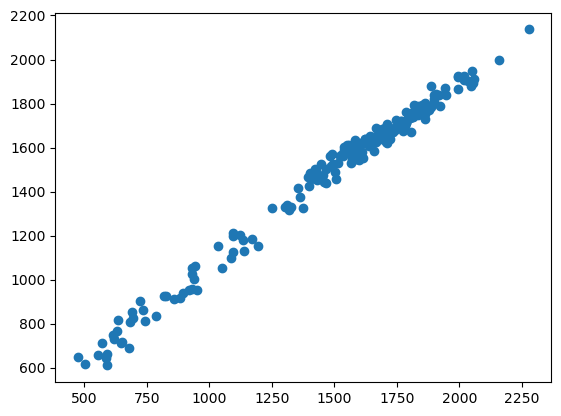

In [116]:
# set model to evaluate model
model.eval()

y_true = torch.tensor([], dtype=torch.float, device=device)
y_pred = torch.tensor([], device=device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for data in train_loader:
        inputs = [i.to(device) for i in data[:-1]]
        labels = data[-1].to(device)

        outputs = model(*inputs)
        y_true = torch.cat((y_true, labels), 0)
        y_pred = torch.cat((y_pred, outputs), 0)

y_true = y_true.cpu().numpy().flatten()
y_pred = y_pred.cpu().numpy().flatten()

print(f"MSE :{mean_squared_error(y_true,y_pred)}")
print(f"ME :{mean_error(y_true,y_pred)}")
print(f"MedAE :{median_absolute_error(y_true,y_pred)}")
print(f"MAPE :{mean_absolute_percentage_error(y_true,y_pred)}")
print(f"R² :{r2_score(y_true,y_pred)}")
print(f"MAE : {mean_absolute_error(y_true,y_pred)}")

f = plt.figure()
s = plt.scatter(y_true, y_pred)
plt.savefig("./results/best_train.jpg")

MSE :10850.0869140625
ME :-9.408967971801758
MedAE :71.389892578125
MAPE :5.892788618803024
R² :0.9287049471425957
MAE : 80.79619598388672


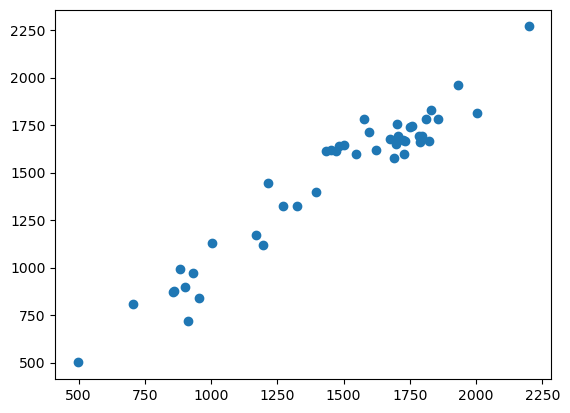

In [117]:
# set model to evaluate model
model.eval()

y_true = torch.tensor([], dtype=torch.float, device=device)
y_pred = torch.tensor([], device=device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for data in val_loader:
        inputs = [i.to(device) for i in data[:-1]]
        labels = data[-1].to(device)

        outputs = model(*inputs)
        y_true = torch.cat((y_true, labels), 0)
        y_pred = torch.cat((y_pred, outputs), 0)

y_true = y_true.cpu().numpy().flatten()
y_pred = y_pred.cpu().numpy().flatten()

print(f"MSE :{mean_squared_error(y_true,y_pred)}")
print(f"ME :{mean_error(y_true,y_pred)}")
print(f"MedAE :{median_absolute_error(y_true,y_pred)}")
print(f"MAPE :{mean_absolute_percentage_error(y_true,y_pred)}")
print(f"R² :{r2_score(y_true,y_pred)}")
print(f"MAE : {mean_absolute_error(y_true,y_pred)}")

f = plt.figure()
s = plt.scatter(y_true, y_pred)
plt.savefig("./results/best_val.jpg")

MSE :8223.337890625
ME :4.354408264160156
MedAE :59.00927734375
MAPE :5.276535823941231
R² :0.9508738160044885
MAE : 75.69200897216797


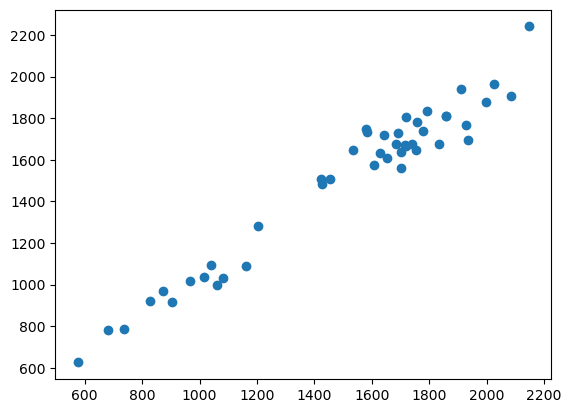

In [118]:
# set model to evaluate model
model.eval()

y_true = torch.tensor([], dtype=torch.float, device=device)
y_pred = torch.tensor([], device=device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for data in test_loader:
        inputs = [i.to(device) for i in data[:-1]]
        labels = data[-1].to(device)

        outputs = model(*inputs)
        y_true = torch.cat((y_true, labels), 0)
        y_pred = torch.cat((y_pred, outputs), 0)

y_true = y_true.cpu().numpy().flatten()
y_pred = y_pred.cpu().numpy().flatten()

correlation_matrix = np.corrcoef(y_true, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(f"MSE :{mean_squared_error(y_true,y_pred)}")
print(f"ME :{mean_error(y_true,y_pred)}")
print(f"MedAE :{median_absolute_error(y_true,y_pred)}")
print(f"MAPE :{mean_absolute_percentage_error(y_true,y_pred)}")
print(f"R² :{r2_score(y_true,y_pred)}")
print(f"MAE : {mean_absolute_error(y_true,y_pred)}")

f = plt.figure()
s = plt.scatter(y_true, y_pred)
plt.savefig("./results/best_test.jpg")